<img src="assets/emc_logo.png" style="vertical-align:middle; float:left;" /> 

# EMC Notebooks

### EMC Model Explorer
_This notebook is in beta_ (r0.5, 2022-09-22)
<hr />


### Read and explore the [EMC Earth model](http://ds.iris.edu/ds/products/emc-earthmodels/) files: 
* Read 2D and 3D EMC-compatible netCDF Earth models in geographic coordinate system
* Display model metadata (in [netCDF](https://www.unidata.ucar.edu/software/netcdf/) or [GeoCSV](http://geows.ds.iris.edu/documents/GeoCSV.pdf) formats)
* Plot map of model's coverage area
* Plot horizontal slices (maps), vertical slices (cross sections), and velocity profiles (line plots vs depth) from model data
* Save the generated plots and their corresponding data
* Output the entire netCDF file or a selected portion of it in GeoCSV format

**Note**: each header cell is identified with either **[R]** or **[O]** to indicate if running the corresponding code cell is required or is optional.



<hr />

#### [R] Import Modules
##### Import Python packages and the EMC utilities package

In [1]:
# Importing packages.
import os
import sys
from pathlib import Path
from collections import namedtuple
import shutil
from IPython.display import Markdown, display, IFrame, HTML, FileLink, clear_output
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import ipywidgets as wg
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings("ignore")

# EMC's utility functions.
import emc_utils as utils
from emc_utils import get_var_name, set_run_arg

# Initialize the run parameters.
run_args = utils.init_run_args()
cell_args = dict()
utils.message("...import done!")



<span style='color:blue; font-weight:bold'>...import done!</span>



<hr />

#### [R] Configure the Notebook
##### Initialize the code parameters and prepare for execution
 
Parameters to set:
* Output dir - Directory where the image and data files will be saved (directory will be created under the parent directory of this notebook)
* Save tag - A string that identifies this runs and will be prepended to the model's output directory's name
* Colormap - The [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to use for the maps
* Save plots  - Save plots under the output directory
* Save data - Save data under the output directory

In [2]:
# The output directory, and store the selected output directory
output_dir_wg =  wg.Text(value=run_args['output_dir'], description='Output dir:', 
                         style={'description_width': 'initial'}, disabled=False)

def on_value_change_1(change):
    if change['new']:
        run_args['output_dir'] = change['new']
output_dir_wg.observe(on_value_change_1, names='value')  
display(output_dir_wg)
output_dir = output_dir_wg.value
run_args = set_run_arg(run_args, 'output_dir', output_dir)

# The Save tag.
save_tag_wg =  wg.Text(value=run_args['save_tag'], description='Save tag:', 
                       style={'description_width': 'initial'}, disabled=False)
def on_value_change_2(change):
    if change['new']:
        run_args['save_tag'] = change['new']
save_tag_wg.observe(on_value_change_2, names='value') 
display(save_tag_wg)
save_tag = save_tag_wg.value
run_args = set_run_arg(run_args, 'save_tag', save_tag)

# Colormap.
colormap_wg =  wg.Text(value=run_args['colormap'], description='Colormap:', 
                       style={'description_width': 'initial'}, disabled=False)
def on_value_change_3(change):
    if change['new']:
        run_args['colormap'] = change['new']
colormap_wg.observe(on_value_change_3, names='value') 
display(colormap_wg)
colormap = colormap_wg.value
run_args = set_run_arg(run_args, 'colormap', colormap)

save_plots_wg = wg.Checkbox(
    value=run_args['save_plots'],
    description='Save plots',
    style={'description_width': 'initial'},
    disabled=False
)
def changed_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['save_plots'] = change['new']

save_plots_wg.observe(changed_0)

display(save_plots_wg)
save_plots = save_plots_wg.value

save_data_wg = wg.Checkbox(
    value=run_args['save_data'],
    description='Save data',
    style={'description_width': 'initial'},
    disabled=False
)
def changed_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['save_data'] = change['new']

save_data_wg.observe(changed_1)
display(save_data_wg)
save_data = save_data_wg.value


Text(value='output', description='Output dir:', style=TextStyle(description_width='initial'))

Text(value='demo', description='Save tag:', style=TextStyle(description_width='initial'))

Text(value='jet_r', description='Colormap:', style=TextStyle(description_width='initial'))

Checkbox(value=True, description='Save plots', style=CheckboxStyle(description_width='initial'))

Checkbox(value=True, description='Save data', style=CheckboxStyle(description_width='initial'))

<hr />

#### [R] Select a Model
##### Select a model file to load. 
 
Parameters to set:
* model_filename - name of the model file to read

In [4]:
# Select the model file.
fc = FileChooser()
# fc.title = f"<b>Current Model file: {run_args['model_filename']}</b>"
fc.default_path = run_args['data_path']
fc.default_filename = run_args['model_filename']
found_model = False
run_args['found_model'] = found_model
if os.path.isfile(os.path.join(run_args['data_path'], run_args['model_filename'])):
    model_file = os.path.join(run_args['data_path'], run_args['model_filename'])
    fc.title = f"<b>Current Model file: {run_args['model_filename']}</b>"
    ds = xr.open_dataset(model_file)
    run_args['coordinate_variables'] = list(ds.coords.keys())
    found_model = True
    run_args['found_model'] = found_model
else:
    fc.title = f"<b>No Model file selected</b>"


# The callback function and store the selected file name and update the title.
def get_selected(chooser):
    if chooser.selected:
        chooser.title = f"<b>Model file: {chooser.selected_filename} selected</b>"
        ds = xr.open_dataset(chooser.selected)
        print(ds)
        if 'id' in ds.attrs:
            model_id = ds.attrs['id']
            run_args['model_id'] = model_id
        run_args['model_filename'] = chooser.selected_filename
        run_args['data_path'] = chooser.selected_path
        run_args['base_filename'] = os.path.splitext(run_args['model_filename'])[0]
        
        ds = xr.open_dataset(model_file)
        run_args['coordinate_variables'] = list(ds.coords.keys())
        found_model = True
        with out:
            clear_output()
            print(ds)
      
# Register callback function
fc.register_callback(get_selected)
display(fc)

out = wg.Output()
display(out)
if found_model:
    if 'id' in ds.attrs:
        model_id = ds.attrs['id']
        run_args['model_id'] = model_id
    
with out:
    clear_output()
    
if found_model:
    print(ds)


FileChooser(path='/Users/manoch/Projects/Notebook/EMC/samples', filename='emc-jnp-iMUSH-localEQ-Ulberg-2020.nc…

Output()

<xarray.Dataset>
Dimensions:     (depth: 55, latitude: 200, longitude: 195)
Coordinates:
  * depth       (depth) float32 -5.0 -3.8 -2.6 -1.4 -0.2 ... 56.2 57.4 58.6 59.8
  * latitude    (latitude) float32 45.19 45.2 45.21 45.22 ... 47.32 47.33 47.34
  * longitude   (longitude) float32 -123.7 -123.7 -123.7 ... -120.7 -120.7
Data variables:
    vp          (depth, latitude, longitude) float32 ...
    vs          (depth, latitude, longitude) float32 ...
    vp_matched  (depth, latitude, longitude) float32 ...
    vs_matched  (depth, latitude, longitude) float32 ...
    vp_large    (depth, latitude, longitude) float32 ...
Attributes: (12/33)
    title:                           iMUSH broadband velocity models
    long_title:                      Velocity models from iMUSH broadband loc...
    id:                              iMUSH_localEQ_Ulberg_2020
    summary:                         iMUSH_localEQ_Ulberg_2020 contains 3-D v...
    comments:                        model converted per IRI

In [5]:
# All good with the model file. Read it. 
model_file = os.path.join(run_args['data_path'],run_args['model_filename'])
if os.path.isfile(model_file):
    ds = xr.open_dataset(model_file)
    run_args['ds'] = ds
    model_data = Dataset(model_file)
    run_args['model_data'] = model_data
else:
    raise ValueError(f"Could not access {model_file}."
                      "Stop! Please select a file in the previous section")

ds = xr.open_dataset(model_file)
if 'id' in ds.attrs:
    model_id = ds.attrs['id']
    run_args['model_id'] = model_id
    
utils.message(f"Model: {run_args['model_id']}")
utils.message(f"Model file: {run_args['model_filename']}")

run_args = set_run_arg(run_args, 'save_data', run_args['save_data'])
run_args = set_run_arg(run_args, 'save_plots', run_args['save_plots'])

# Initialize the model variable and set the data path.
default_data_var = ''
root_path = run_args['root_path']
data_path = run_args['data_path']
run_args = set_run_arg(run_args, 'data_path', data_path)
ndim = dict()
valid_dimensions = run_args['valid_dimensions']
model_filename = run_args['model_filename']
  
# Base file name.
base_filename = os.path.splitext(model_filename)[0]
output_path = os.path.join(root_path, output_dir)

# Make sure the output directory is accessible.
# Create if it does not exist.
output_path = os.path.join(root_path, output_dir)
try:
    output_path = utils.make_path(output_path)   
except:
    raise ValueError(f"Could not access or create the data directory {output_path}"
                     f"\nStop! Please update the 'output_dir' value")
    
# Create an output directory for this model.
try:
    output_path = utils.make_path(os.path.join(output_path, f"{save_tag}-{base_filename}"))  
    run_args = set_run_arg(run_args, 'output_path', output_path)    
except:
    raise ValueError(f"Could not access or create the output directory {output_path} for the model\n"
                     f"\nStop! Please update the 'output_dir' value")
run_args = set_run_arg(run_args, 'output_path', output_path)

# Load the model and tell the user that the model file is loaded.
ds = xr.open_dataset(model_file)
if 'id' in ds.attrs:
    model_id = ds.attrs['id']
else:
    model_id = ''
        
run_args = set_run_arg(run_args, 'id', id) 
run_args = set_run_arg(run_args, 'ds', ds)

model_variables = list(model_data.variables)
run_args = set_run_arg(run_args, 'model_variables', model_variables)

coordinate_variables = list(ds.coords)

run_args = set_run_arg(run_args, 'coordinate_variables', coordinate_variables)
ndim['model'] = len(coordinate_variables)
data_variables = list(set(model_variables) - set(coordinate_variables))
run_args = set_run_arg(run_args, 'data_variables', data_variables)

if data_variables:
    # Make sure the current default variable (if exists) is valid.
    if 'default_data_var' in run_args:
        if run_args['default_data_var'] not in data_variables:
            run_args = set_run_arg(run_args, 'default_data_var', data_variables[0])
            
    # Set the default variable if it does not exist.
    if 'default_data_var' not in run_args:
        run_args = set_run_arg(run_args, 'default_data_var', data_variables[0])
    run_args['variable_list'] = data_variables  
    run_args['csv_data_var'] = data_variables 
    data_variables_wg = wg.Dropdown(options=run_args['variable_list'], value=run_args['default_data_var'], 
                                    description='Model var:', disabled=False)
    def var_on_change(var_change):
        if var_change['type'] == 'change' and var_change['name'] == 'value':
            run_args['default_data_var'] = var_change['new']
            with out:
                clear_output()
                for item in list(ds[var_change['new']].variable.attrs.items()):
                    print (f"{': '.join(item)}")


    
    data_variables_wg.observe(var_on_change)
    display(data_variables_wg)
    
    out = wg.Output()
    display(out)
    default_data_var = data_variables_wg.value
    
    with out:
        clear_output()
        for item in list(ds[default_data_var].variable.attrs.items()):
                    print (f"{': '.join(item)}")
for var in data_variables:
    ndim[var] = len(model_data.variables[var].dimensions)
    if ndim[var] not in list(valid_dimensions):
        valid_dims = list(valid_dimensions.values())
        raise ValueError(f"{var} is a {ndim[var]}D model. This Notebook currently accepts"
                         f"{' & '.join(valid_dims)} models only!"
                         f"\nStop! Please assign a different model to 'model_filename'")

# Notebook works with 2D and 3D models only.
if ndim['model'] not in list(valid_dimensions):
    raise ValueError(f"This model is a {ndim}D model. This Notebook currently accepts"
                     f"{' & '.join(valid_dims)} models only!"
                     f"\nStop! Please assign a different model to 'model_filename'")
run_args = set_run_arg(run_args, 'ndim', ndim)




<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>



Dropdown(description='Model var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), value='vp_lar…

Output()

<hr />

#### [R] Select the Data Variable
##### Select the default model variable to display

* Set the default model data variable to use


<hr />

#### [R] Assign Axis
##### Assign directions to the coordinate variables

Define direction of each coordinate variable:
* X Variable - Variable that represents the **X** direction (e.g. longitude)
* Y Variable - Variable that represents the **Y** direction (e.g. latitude)
* Z Variable - For the 3D models, the variable that represents the **Z** direction (e.g. depth). Ignored for the 2D models.

In [6]:
coordinate_variables = run_args['coordinate_variables'] 
    
utils.message(f"Model: {run_args['model_id']}")
utils.message(f"Model file: {run_args['model_filename']}")

# Model dimensions.
if run_args['default_x_var'] in coordinate_variables:
    x_variable_wg = wg.Dropdown(options=coordinate_variables, value=run_args['default_x_var'], 
                                description='X variable:', 
                                style={'description_width': 'initial'}, disabled=False)
else:
    x_variable_wg = wg.Dropdown(options=coordinate_variables, value=coordinate_variables[0], 
                                description='X variable:', 
                                style={'description_width': 'initial'}, disabled=False)
def ax_on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['default_x_var'] = change['new']

x_variable_wg.observe(ax_on_change_0)
display(x_variable_wg)
default_x_var = x_variable_wg.value

if run_args['default_y_var'] in coordinate_variables:
    y_variable_wg = wg.Dropdown(options=coordinate_variables, value=run_args['default_y_var'], 
                                description='Y variable:', 
                                style={'description_width': 'initial'}, disabled=False)
else:
    y_variable_wg = wg.Dropdown(options=coordinate_variables, value=coordinate_variables[0], 
                                description='Y variable:', 
                                style={'description_width': 'initial'}, disabled=False)
        
def ax_on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['default_y_var'] = change['new']

y_variable_wg.observe(ax_on_change_1)
display(y_variable_wg)
default_y_var = y_variable_wg.value

if ndim['model'] == 3:
    if run_args['default_z_var'] in coordinate_variables:
        z_variable_wg = wg.Dropdown(options=coordinate_variables, value=run_args['default_z_var'], 
                                    description='Z variable:', 
                                    style={'description_width': 'initial'}, disabled=False)
    else:
        z_variable_wg = wg.Dropdown(options=coordinate_variables, value=coordinate_variables[0], 
                                    description='Z variable:', 
                                    style={'description_width': 'initial'}, disabled=False)
        
    def ax_on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['default_z_var'] = change['new']

    z_variable_wg.observe(ax_on_change_2)
    display(z_variable_wg)
    default_z_var = z_variable_wg.value
    
x_variable =  run_args['default_x_var']
run_args = set_run_arg(run_args, 'x_variable', x_variable)
x_values = model_data.variables[x_variable][:]
if max(abs(x_values)) > 180.0:
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    ds = ds.sortby(x_variable)
    run_args = set_run_arg(run_args, 'ds', ds)     
x_values = ds[x_variable][:]
run_args = set_run_arg(run_args, 'x_values', x_values)
x_data = x_values
run_args = set_run_arg(run_args, 'min_x', min(x_values))
run_args = set_run_arg(run_args, 'max_x', max(x_values))
run_args = set_run_arg(run_args, 'x_range', [min(x_values), max(x_values)])
run_args = set_run_arg(run_args, 'csv_x_range', [min(x_values), max(x_values)])
  
y_variable =  run_args['default_y_var']    
if y_variable not in model_variables:
    raise UserWarning(f"The 'y_variable' = '{y_variable}' is not one of the model coordinates {coordinate_variables}"
                      "Stop! Please update the 'y_variable'")
run_args = set_run_arg(run_args, 'y_variable', y_variable)
y_values = model_data.variables[y_variable][:]
run_args = set_run_arg(run_args, 'y_values', y_values)
y_data = y_values
run_args = set_run_arg(run_args, 'min_y', min(y_values))
run_args = set_run_arg(run_args, 'max_y', max(y_values))
run_args = set_run_arg(run_args, 'y_range', [min(y_values), max(y_values)])
run_args = set_run_arg(run_args, 'csv_y_range', [min(y_values), max(y_values)])

if ndim['model'] == 2:
    z_variable = None
    z_values = None
else:
    z_variable =  run_args['default_z_var']
    if z_variable not in model_variables:
        raise UserWarning(f"The 'z_variable' = '{z_variable}' is not one of the model coordinates {coordinate_variables}"
                          "Stop! Please update the 'z_variable'")
    z_values = model_data.variables[z_variable][:]

    run_args = set_run_arg(run_args, 'z_variable', z_variable)
    run_args = set_run_arg(run_args, 'z_values', z_values)
    z_data = z_values
    if len(z_values):
        run_args = set_run_arg(run_args, 'min_z', min(z_values))
        run_args = set_run_arg(run_args, 'max_z', max(z_values))
        run_args = set_run_arg(run_args, 'z_range', [min(z_values), max(z_values)])
        run_args = set_run_arg(run_args, 'csv_z_range', [min(z_values), max(z_values)])
        run_args = set_run_arg(run_args, 'z_step', 5)
    else:
        run_args = set_run_arg(run_args, 'min_z', None)
        run_args = set_run_arg(run_args, 'max_z', None)
        run_args = set_run_arg(run_args, 'z_range', [])
        run_args = set_run_arg(run_args, 'csv_z_range', [])
        run_args = set_run_arg(run_args, 'z_step', 1)
    
# Tell the user about the model dimension.
display(Markdown(f"\n\n<font color='blue'>Model {model_filename} contains {ndim['model']}D variables. </font>\n\n"))



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>



Dropdown(description='X variable:', index=2, options=('depth', 'latitude', 'longitude'), style=DescriptionStyl…

Dropdown(description='Y variable:', index=1, options=('depth', 'latitude', 'longitude'), style=DescriptionStyl…

Dropdown(description='Z variable:', options=('depth', 'latitude', 'longitude'), style=DescriptionStyle(descrip…



<font color='blue'>Model emc-jnp-iMUSH-localEQ-Ulberg-2020.nc contains 3D variables. </font>



<hr />

#### [O] Model Metadata
##### Display the model metadata 

In [7]:
# Display the model metatada (header).
utils.message(f"{model_id}")
utils.message(f"{model_filename} model file:")

model_metadata_wg = wg.RadioButtons(
    options=['None', 'netCDF', 'GeoCSV'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Model metadata display format:',
    disabled=False
)

output_meta = wg.Output()
display(model_metadata_wg, output_meta)

def what_traits_radio(value):
    output_meta.clear_output()
    with output_meta:
        utils.display_header(model_filename, model_data, run_args, metadata_format=value.new)

model_metadata_wg.observe(what_traits_radio, names = 'value')




<span style='color:blue; font-weight:bold'>iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>emc-jnp-iMUSH-localEQ-Ulberg-2020.nc model file:</span>



RadioButtons(description='Model metadata display format:', options=('None', 'netCDF', 'GeoCSV'), value='None')

Output()

<hr />
<!--img src="assets/IRIS_web.png" id='iris' style="vertical-align:top; float:right;" /--> 

#### [O] EMC Model Page
##### Display EMC's model detail page.

In [8]:
if 'repository_pid' in ds.attrs:
    if ds.attrs['repository_pid']:
        repository_doi, repository_url = utils.pid_to_url(ds.attrs, 'repository_pid')
        utils.message(f"Model: {model_id}")
        utils.message(f"Model file: {model_filename}")
        if repository_doi is not None: 
            run_args = set_run_arg(run_args, 'repository_doi', repository_doi)
            run_args = set_run_arg(run_args, 'repository_url', repository_url)
            utils.message(f"Repository DOI: {repository_doi}")
            utils.message(f"Repository URL: {repository_url}\n")
            display(IFrame(repository_url, run_args['frame_size'][0],run_args['frame_size'][1]))    
        else:
             utils.message("No repositoy DOI found", color='red')  
else:
    utils.message("No repositoy PID found", color='red')  



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Repository DOI: https://doi.org/10.17611/dp/emc.2020.imushloceq.1</span>





<span style='color:blue; font-weight:bold'>Repository URL: http://ds.iris.edu/ds/products/emc-imush_localeq_ulberg_2020/
</span>



<hr />

#### [O] Model Coverage
##### Display values assigned to each of the model coordinate variables and show a map of the coverage area.



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





## longitude:


<xarray.DataArray 'longitude' (longitude: 195)>
array([-123.714 , -123.6984, -123.6828, -123.6672, -123.6516, -123.6361,
       -123.6205, -123.6049, -123.5893, -123.5737, -123.5582, -123.5426,
       -123.527 , -123.5114, -123.4958, -123.4803, -123.4647, -123.4491,
       -123.4335, -123.418 , -123.4024, -123.3868, -123.3712, -123.3556,
       -123.3401, -123.3245, -123.3089, -123.2933, -123.2777, -123.2622,
       -123.2466, -123.231 , -123.2154, -123.1999, -123.1843, -123.1687,
       -123.1531, -123.1375, -123.122 , -123.1064, -123.0908, -123.0752,
       -123.0596, -123.0441, -123.0285, -123.0129, -122.9973, -122.9817,
       -122.9662, -122.9506, -122.935 , -122.9194, -122.9039, -122.8883,
       -122.8727, -122.8571, -122.8415, -122.826 , -122.8104, -122.7948,
       -122.7792, -122.7636, -122.7481, -122.7325, -122.7169, -122.7013,
       -122.6857, -122.6702, -122.6546, -122.639 , -122.6234, -122.6078,
       -122.5923, -122.5767, -122.5611, -122.5455, -122.53  , -122.5144,
   



## latitude:


[45.18986 45.20065 45.21145 45.22224 45.23304 45.24384 45.25463 45.26543
 45.27622 45.28701 45.29781 45.30861 45.3194  45.3302  45.34099 45.35179
 45.36258 45.37337 45.38417 45.39497 45.40576 45.41656 45.42735 45.43814
 45.44894 45.45974 45.47053 45.48133 45.49212 45.50292 45.51371 45.52451
 45.5353  45.5461  45.55689 45.56769 45.57848 45.58928 45.60007 45.61087
 45.62166 45.63246 45.64325 45.65405 45.66484 45.67564 45.68643 45.69723
 45.70802 45.71882 45.72961 45.74041 45.75121 45.762   45.77279 45.78359
 45.79438 45.80518 45.81598 45.82677 45.83757 45.84836 45.85915 45.86995
 45.88074 45.89154 45.90234 45.91313 45.92392 45.93472 45.94551 45.95631
 45.96711 45.9779  45.9887  45.99949 46.01028 46.02108 46.03188 46.04267
 46.05347 46.06426 46.07506 46.08585 46.09665 46.10744 46.11824 46.12903
 46.13983 46.15062 46.16142 46.17221 46.18301 46.1938  46.2046  46.21539
 46.22619 46.23698 46.24778 46.25857 46.26937 46.28016 46.29096 46.30175
 46.31255 46.32335 46.33414 46.34493 46.35573 46.36



## depth:


[-5.  -3.8 -2.6 -1.4 -0.2  1.   2.2  3.4  4.6  5.8  7.   8.2  9.4 10.6
 11.8 13.  14.2 15.4 16.6 17.8 19.  20.2 21.4 22.6 23.8 25.  26.2 27.4
 28.6 29.8 31.  32.2 33.4 34.6 35.8 37.  38.2 39.4 40.6 41.8 43.  44.2
 45.4 46.6 47.8 49.  50.2 51.4 52.6 53.8 55.  56.2 57.4 58.6 59.8]


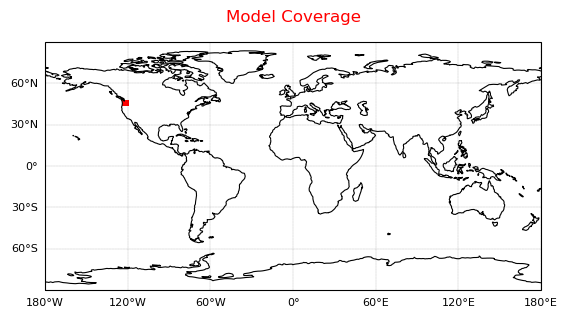

In [9]:
print()
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")
utils.plot_model_area(x_variable, x_values, y_variable, y_values, run_args['projection'])

display(Markdown(f"\n\n## {x_variable}:\n"))
print(x_values)


display(Markdown(f"\n\n## {y_variable}:\n"))
print(y_values)

if z_values is not None and ndim['model'] > 2:
    display(Markdown(f"\n\n## {z_variable}:\n"))
    
    np.set_printoptions(precision=2)
    print(z_values)

<hr />
<!--img src="assets/emc_hslice.png" id='horizontalslice' style="vertical-align:top; float:right;" /--> 

#### [O] Horizontal Slices
##### Plot one or more horizontal (depth) slices 

* Horizontal slice var - Model variable to create the horizontal slices for
* X Variable range - Plot range (min, max) along the X coordinate 
* Y Variable range - Plot range (min, max) along the Y coordinate 
* Z Variable range - Plot range (min, max) along the Z coordinate (3D models only) 
* Z Variable step - The step used for decimating (resampling) the Z values (set to **1** for all values)





<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Model data variables: ['vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp']</span>





<span style='color:blue; font-weight:bold'>Data variable: vp_large</span>



vp_large


Dropdown(description='Horizontal slice var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), st…

FloatRangeSlider(value=(-123.71399688720703, -120.69170379638672), continuous_update=False, description='longi…

FloatRangeSlider(value=(45.18986129760742, 47.33808135986328), continuous_update=False, description='latitude:…

FloatRangeSlider(value=(-5.0, 59.79999923706055), continuous_update=False, description='depth:', max=59.799999…

IntSlider(value=5, continuous_update=False, description='depth step:', max=54, min=1)

longitude range -123.71 to -120.69 / -123.71 to -120.69
latitude range 45.19 to 47.34 / 45.19 to 47.34
depth range -5.00 to 59.80 / -5.00 to 59.80
depth values for step 5:  [-5.0, 1.0, 7.0, 13.0, 19.0, 25.0, 31.0, 37.0, 43.0, 49.0, 55.0]




<span style='color:blue; font-weight:bold'>Plotting: vp_large</span>



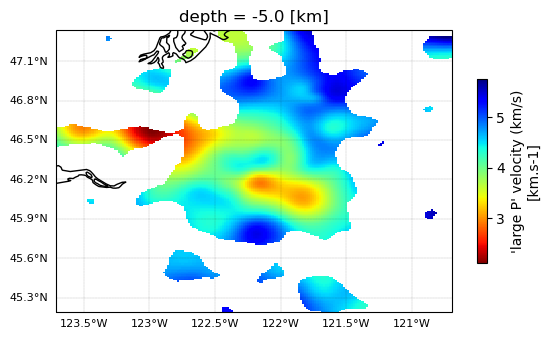

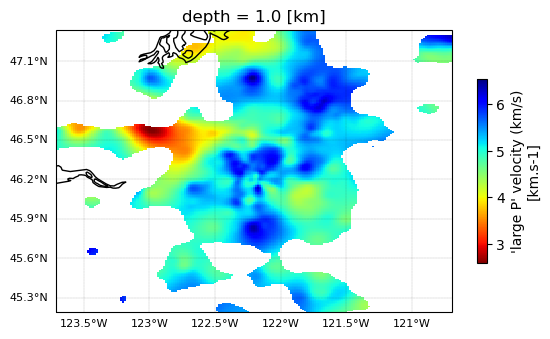

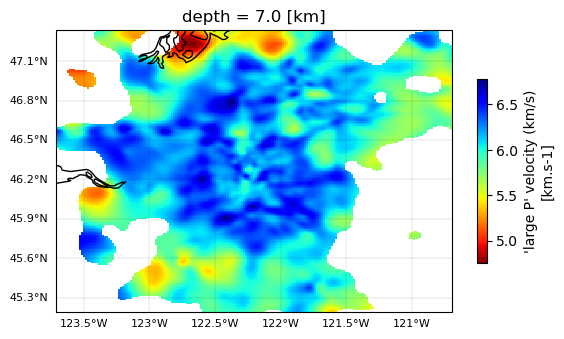

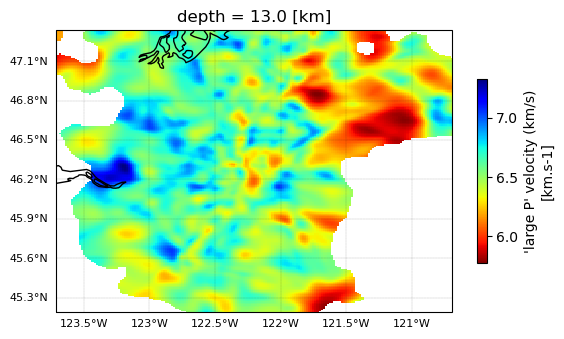

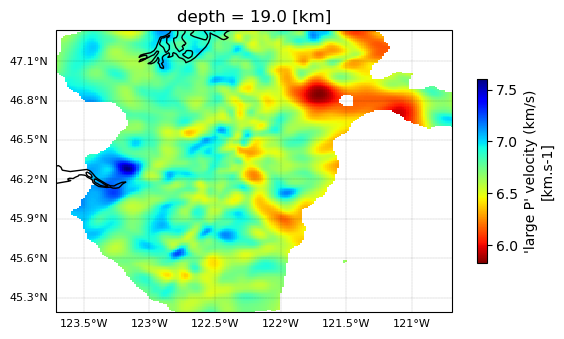

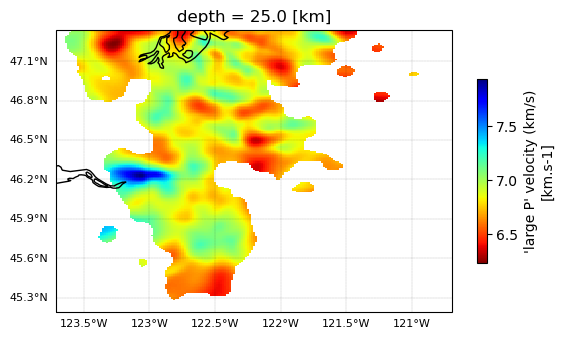

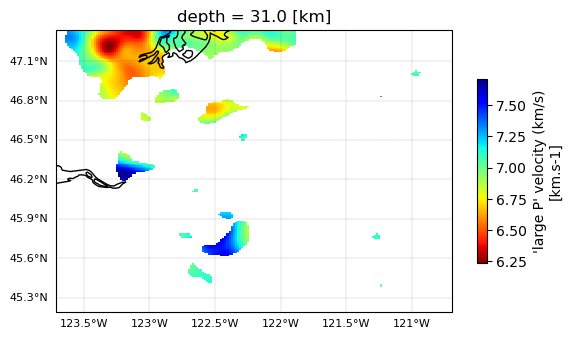

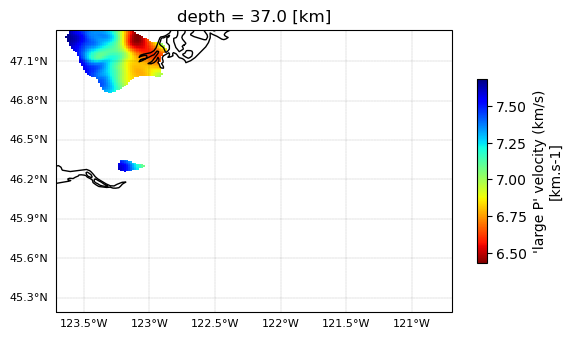

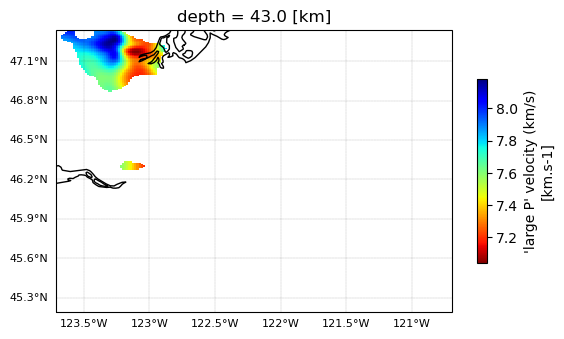

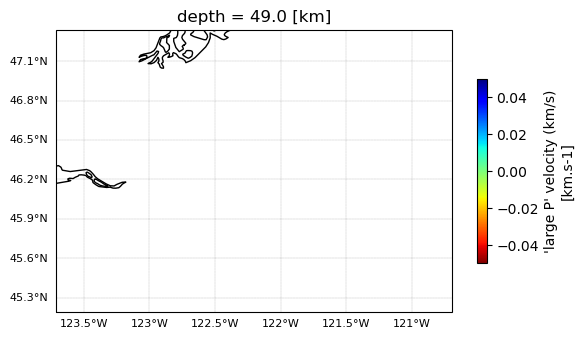

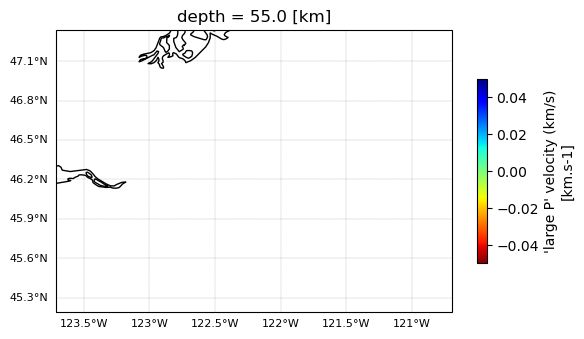

In [10]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")
utils.message(f"Model data variables: {data_variables}")

if 'hslice_var' not in run_args:
    hslice_var = run_args['default_data_var'] 
    run_args = set_run_arg(run_args, 'hslice_var', hslice_var)
elif run_args['hslice_var'] not in data_variables:
    hslice_var = run_args['default_data_var'] 
    run_args['hslice_var'] = hslice_var
else:
    run_args = set_run_arg(run_args, 'hslice_var', run_args['hslice_var'])

utils.message(f"Data variable: {hslice_var}")
print(run_args['hslice_var'])
hsclice_variables_wg = wg.Dropdown(options=data_variables, value=run_args['hslice_var'], 
                                   style={'description_width': 'initial'}, description='Horizontal slice var:', 
                                   disabled=False)
changed = False
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['hslice_var'] = change['new']
        change['value'] = change['new']
        changed = True
        
hsclice_variables_wg.observe(on_change)
display(hsclice_variables_wg)
if changed:
    run_args = set_run_arg(run_args, 'hslice_var',  data_variables_wg.value)
    
x_range_wg = wg.FloatRangeSlider(
    value=run_args['x_range'],
    min=run_args['min_x'],
    max=run_args['max_x'],
    step=0.1,
    description= f"{x_variable}:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['x_range'] = [change['new'][0], change['new'][1]]
    
x_range_wg.observe(on_change_0, 'value')

display(x_range_wg)

y_range_wg = wg.FloatRangeSlider(
    value=run_args['y_range'],
    min=run_args['min_y'],
    max=run_args['max_y'],
    step=0.1,
    description=f"{y_variable}:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_range'] = [change['new'][0], change['new'][1]]
    
y_range_wg.observe(on_change_1, 'value')

display(y_range_wg)

if z_values is not None and ndim['model'] > 2:
    z_range_wg = wg.FloatRangeSlider(
    value=run_args['z_range'],
    min=run_args['min_z'],
    max=run_args['max_z'],
    step=0.1,
    description=f"{z_variable}:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    
    def on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_range'] = [change['new'][0], change['new'][1]]

    z_range_wg.observe(on_change_2, 'value')

    display(z_range_wg)

    z_step_wg = wg.IntSlider(
    value=run_args['z_step'],
    min=1,
    max=len(z_data) - 1,
    step=1,
    description=f"{z_variable} step:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
    )
    
    def on_change_3(change):
        run_args['z_step'] = change['new']

    z_step_wg.observe(on_change_3, 'value')

    display(z_step_wg)

# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Z values are used only for 3D models. Use Z_STEP to decimate (resample) the Z values (set Z_STEP = 1 for all Zs).

x_range = run_args['x_range'] 
y_range = run_args['y_range'] 
if ndim['model'] == 2:
    z_range = list()
    z_step = 1
else:
    z_range = run_args['z_range']
    z_step = run_args['z_step']

x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                    y_variable, y_range, y_values, 
                                                                                    z_variable, z_range, z_values, 
                                                                                    ndim['model'])

if z_step > 1:
    print(f"{z_variable} values for step {z_step}: ", z_data[::z_step])
dsv = utils.get_dsv(ds, run_args['hslice_var'])
if ndim[run_args['hslice_var']] == 3:
    z = utils.get_range_values(z_values, (z_min, z_max))
else:
    z = [1]

dsv = ds[run_args['hslice_var']]

if 'display_name' in dsv.variable.attrs:
    title = dsv.variable.attrs['display_name']
elif 'long_name' in dsv.variable.attrs:
    title = dsv.variable.attrs['long_name']
else:
    title = data_var

utils.message(f"Plotting: {run_args['hslice_var']}")

if ndim[run_args['hslice_var']] == 3:
    for _z in z[::z_step]:
        if ndim[run_args['hslice_var']] == 3:
            zslice = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                                    (dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max) &
                                    (dsv[z_variable] == _z), drop=True)
        plt = utils.plot_hslice(zslice, x_variable, x_min, x_max, y_variable, y_min, y_max, title, colormap, 
                               run_args['projection'])
        utils.save_files(save_data, save_plots, zslice, plt, f"Z{_z:0.1f}km", run_args['hslice_var'], run_args['delimiter'], base_filename, run_args['file_extensions'], output_path)
        plt.show()
else:
    zslice = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                    (dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max), drop=True)
    plt = utils.plot_hslice(zslice, x_variable, x_min, x_max, y_variable, y_min, y_max, title, colormap,
                           run_args['projection'])
    utils.save_files(save_data, save_plots, zslice, plt, f"Z", run_args['hslice_var'], run_args['delimiter'], base_filename, run_args['file_extensions'], output_path)








<hr />
<!--img src="assets/emc_xsection_x.png" id='verticalx' style="vertical-align:top; float:right;" /--> 

#### [O] Vertical Slices Along the X-axis
##### For a 3D data variable, plot vertical slices (cross sections) along the X-axis

* Vertical slice var - Model variable to create the vertical slices for
* X Variable range - Plot range (min, max) along the X coordinate 
* X Variable step - The step used for decimating (resampling) the X values (set to **1** for all values)
* Y Variable range - Plot range (min, max) along the Y coordinate 
* Z Variable range - Plot range (min, max) along the Z coordinate (3D models only) 
* Z exaggeration - The vertical exaggeration for the cross-section



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Model data variables: vp_large</span>



Dropdown(description='Vertical X-slice var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), st…

FloatRangeSlider(value=(-123.71399688720703, -120.69170379638672), continuous_update=False, description='Longi…

IntSlider(value=30, continuous_update=False, description='Longitude step:', max=194, min=1, style=SliderStyle(…

FloatRangeSlider(value=(45.18986129760742, 47.33808135986328), continuous_update=False, description='Latitude:…

FloatRangeSlider(value=(-5.0, 59.79999923706055), continuous_update=False, description='Depth:', max=59.799999…

IntSlider(value=10, continuous_update=False, description='Depth exaggeration:', max=30, min=1, style=SliderSty…

longitude range -123.71 to -120.69 / -123.71 to -120.69
latitude range 45.19 to 47.34 / 45.19 to 47.34
depth range -5.00 to 59.80 / -5.00 to 59.80
depth values for step 5:  [-5.0, 1.0, 7.0, 13.0, 19.0, 25.0, 31.0, 37.0, 43.0, 49.0, 55.0]


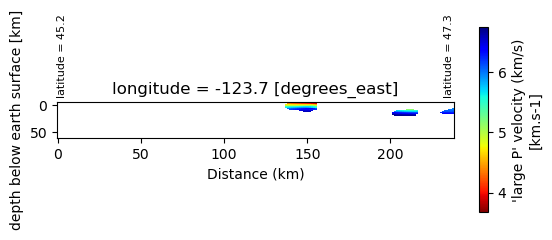

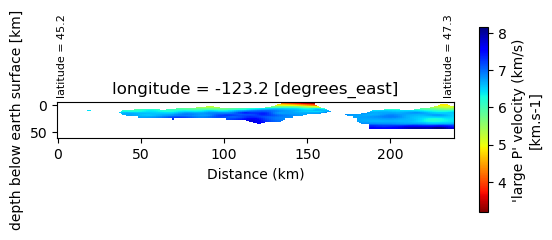

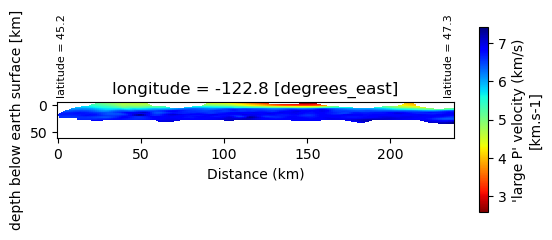

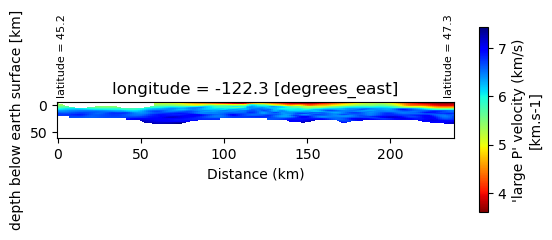

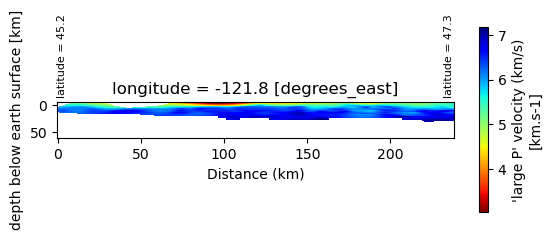

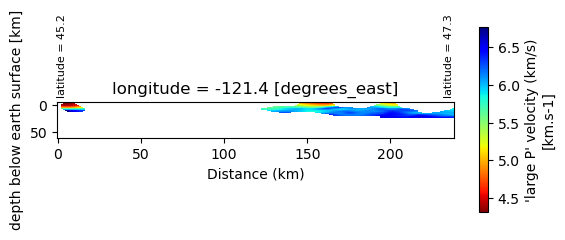

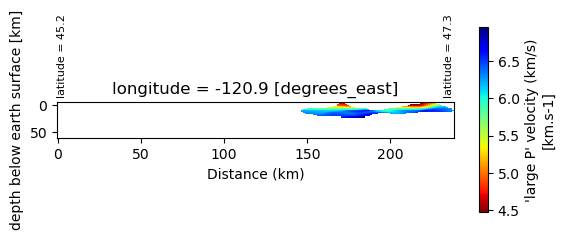



<span style='color:blue; font-weight:bold'>...done!</span>



In [11]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")

if 'xvslice_var' not in run_args:
    xvslice_var = run_args['default_data_var'] 
    run_args = set_run_arg(run_args, 'xvslice_var', xvslice_var)
elif run_args['xvslice_var'] not in data_variables:
    xvslice_var = run_args['default_data_var'] 
    run_args['xvslice_var'] = xvslice_var
    
xvslice_var = run_args['xvslice_var']

utils.message(f"Model data variables: {xvslice_var}")

xvslice_variables_wg = wg.Dropdown(options=data_variables, value=run_args['xvslice_var'], 
                                   style={'description_width': 'initial'}, description='Vertical X-slice var:', 
                                   disabled=False)
changed = False
def xvs_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['xvslice_var'] = change['new']
        change['value'] = change['new']
        changed = True
        
xvslice_variables_wg.observe(xvs_on_change)
display(xvslice_variables_wg)
if changed:
    run_args = set_run_arg(run_args, 'xvslice_var',  data_variables_wg.value)
    
x_range_wg = wg.FloatRangeSlider(
    value=run_args['x_range'],
    min=run_args['min_x'],
    max=run_args['max_x'],
    step=0.1,
    description= f"{x_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def xvs_on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['x_range'] = [change['new'][0], change['new'][1]]
    
x_range_wg.observe(xvs_on_change_0, 'value')

display(x_range_wg)

x_step = run_args['x_step']
x_step_wg = wg.IntSlider(
    value=run_args['x_step'],
    min=1,
    max=len(x_data) - 1,
    step=1,
    description=f"{x_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def xvs_on_change_3(change):
    run_args['x_step'] = change['new']

x_step_wg.observe(xvs_on_change_3, 'value')

display(x_step_wg)
    
y_range_wg = wg.FloatRangeSlider(
    value=run_args['y_range'],
    min=run_args['min_y'],
    max=run_args['max_y'],
    step=0.1,
    description=f"{y_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def xvs_on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_range'] = [change['new'][0], change['new'][1]]
    
y_range_wg.observe(xvs_on_change_1, 'value')

display(y_range_wg)

if z_values is not None and ndim['model'] > 2:
    z_range_wg = wg.FloatRangeSlider(
    value=run_args['z_range'],
    min=run_args['min_z'],
    max=run_args['max_z'],
    step=0.1,
    description=f"{z_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    
    def xvs_on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_range'] = [change['new'][0], change['new'][1]]

    z_range_wg.observe(xvs_on_change_2, 'value')

    display(z_range_wg)

    z_exaggeration_wg = wg.IntSlider(
    value=run_args['z_exaggeration'],
    min=1,
    max=run_args['max_exaggeration'],
    step=1,
    description=f"{z_variable} exaggeration:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'} 
    )

    def xvs_on_change_4(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_exaggeration'] = change['new']

    z_exaggeration_wg.observe(xvs_on_change_4, 'value')

    display(z_exaggeration_wg)


# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Z values are used only for 3D models. Use Z_STEP to decimate (resample) the Z values (set Z_STEP = 1 for all Zs).

if ndim[xvslice_var] != 3:
    utils.message(f"{xvslice_var} is a {ndim[xvslice_var]}D variable. Plot of the vertical slices (cross sections) is only for 3D variables", color='red')
else:    
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[xvslice_var])

    if z_step > 1:
        print(f"{z_variable} values for step {z_step}: ", z_data[::z_step])
    dsv = utils.get_dsv(ds, run_args['xvslice_var'])
    if ndim[run_args['xvslice_var']] == 3:
        z = utils.get_range_values(z_values, (z_min, z_max))
    else:
        z = [1]
    
    x = utils.get_range_values(x_values, (x_min, x_max))
    dsv = utils.get_dsv(ds, xvslice_var)
    for _x in x[::x_step]:
        xsection = dsv.where((dsv[y_variable] >= y_min) & (dsv[y_variable] <= y_max) &
                                (dsv[z_variable] >= z_min) & (dsv[z_variable] <= z_max) &
                                (dsv[x_variable] == _x), drop=True)
        
        lon = xsection.longitude.values[0]
        lat_values = xsection.latitude.values
        dist = list()
        for lat_index, lat in enumerate(lat_values):
            if lat_index == 0:
                dist.append(0)
                lat0 = lat
            else:
                _dist = utils.great_circle_distance(lat0, lon, lat, lon)
                dist.append(_dist)

        xsection['latitude'] = ('latitude', np.array(dist))
        im = xsection.plot(x="latitude", y="depth", cmap=colormap, cbar_kwargs={'shrink': 0.5})
        xy_ratio = utils.calc_xy_ratio((y_max, y_min), (z_max, z_min), factor=run_args['z_exaggeration'])
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xlabel('Distance (km)')
        ax.set_aspect(xy_ratio)
                
        ax.text(0, 1.1, f"latitude = {y_min:0.1f}",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)

        ax.text(1, 1.1, f"latitude = {y_max:0.1f}",
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)
        utils.save_files(save_data, save_plots, xsection, plt, f"X{_x:0.1f}km", xvslice_var, run_args['delimiter'], 
                         base_filename, run_args['file_extensions'], output_path)
        plt.show()

utils.message("...done!")

<hr />
<!--img src="assets/emc_xsection_y.png" id="verticaly" style="vertical-align:top; float:right;" /--> 

#### [O] Vertical Slices Along the Y-axis
##### For a 3D model, plot vertical slices (cross sections) along the Y-axis

* Vertical slice var - Model variable to create the vertical slices for
* X Variable range - Plot range (min, max) along the X coordinate 
* Y Variable range - Plot range (min, max) along the Y coordinate 
* Y Variable step - The step used for decimating (resampling) the Y values (set to **1** for all values)
* Z Variable range - Plot range (min, max) along the Z coordinate (3D models only) 
* Z exaggeration - The vertical exaggeration for the cross-section



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Model data variables: vp_large</span>



Dropdown(description='Vertical X-slice var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), st…

FloatRangeSlider(value=(-123.71399688720703, -120.69170379638672), continuous_update=False, description='Longi…

FloatRangeSlider(value=(45.18986129760742, 47.33808135986328), continuous_update=False, description='Latitude:…

IntSlider(value=30, continuous_update=False, description='Latitude step:', max=199, min=1, style=SliderStyle(d…

FloatRangeSlider(value=(-5.0, 59.79999923706055), continuous_update=False, description='Depth:', max=59.799999…

IntSlider(value=10, continuous_update=False, description='Depth exaggeration:', max=30, min=1, style=SliderSty…

longitude range -123.71 to -120.69 / -123.71 to -120.69
latitude range 45.19 to 47.34 / 45.19 to 47.34
depth range -5.00 to 59.80 / -5.00 to 59.80


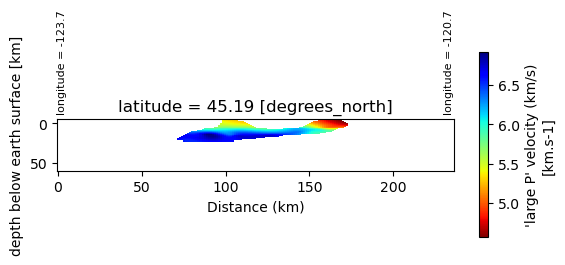

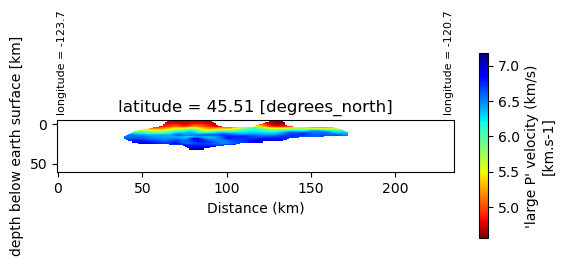

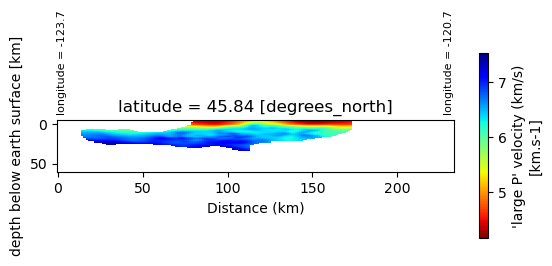

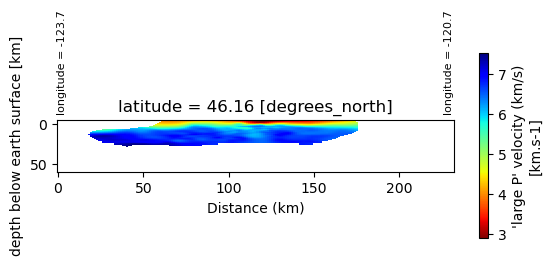

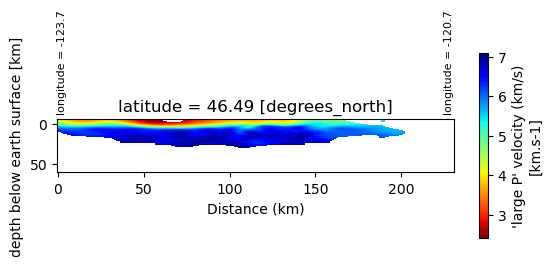

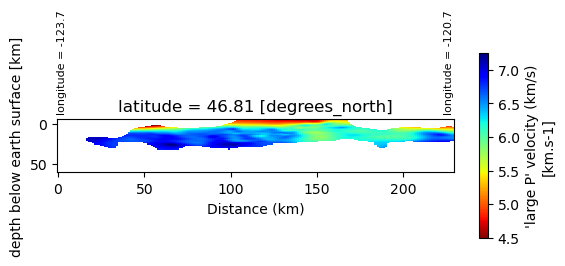

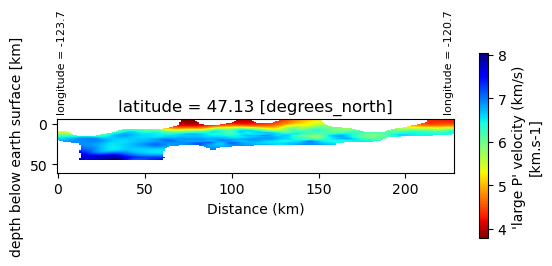



<span style='color:[45.18986, 47.33808]; font-weight:bold'>...done!</span>



In [12]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")

if 'yvslice_var' not in run_args:
    yvslice_var = run_args['default_data_var'] 
    run_args = set_run_arg(run_args, 'yvslice_var', yvslice_var)
elif run_args['yvslice_var'] not in data_variables:
    yvslice_var = run_args['default_data_var'] 
    run_args['yvslice_var'] = yvslice_var
    
yvslice_var = run_args['yvslice_var']

utils.message(f"Model data variables: {yvslice_var}")


yvslice_variables_wg = wg.Dropdown(options=data_variables, value=run_args['yvslice_var'], 
                                   style={'description_width': 'initial'}, description='Vertical X-slice var:', 
                                   disabled=False)
changed = False
def yvs_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['yvslice_var'] = change['new']
        change['value'] = change['new']
        changed = True
        
yvslice_variables_wg.observe(yvs_on_change)
display(yvslice_variables_wg)
if changed:
    run_args = set_run_arg(run_args, 'yvslice_var',  data_variables_wg.value)
    
x_range_wg = wg.FloatRangeSlider(
    value=run_args['x_range'],
    min=run_args['min_x'],
    max=run_args['max_x'],
    step=0.1,
    description= f"{x_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def yvs_on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['x_range'] = [change['new'][0], change['new'][1]]
    
x_range_wg.observe(yvs_on_change_0, 'value')

display(x_range_wg)
    
y_range_wg = wg.FloatRangeSlider(
    value=run_args['y_range'],
    min=run_args['min_y'],
    max=run_args['max_y'],
    step=0.1,
    description=f"{y_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def yvs_on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_range'] = [change['new'][0], change['new'][1]]
    
y_range_wg.observe(yvs_on_change_1, 'value')

display(y_range_wg)
                                                         
y_step = run_args['y_step']
y_step_wg = wg.IntSlider(
    value=run_args['y_step'],
    min=1,
    max=len(y_data) - 1,
    step=1,
    description=f"{y_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def yvs_on_change_3(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_step'] = change['new']

y_step_wg.observe(yvs_on_change_3, 'value')

display(y_step_wg)
                                                             
if z_values is not None and ndim['model'] > 2:
    z_range_wg = wg.FloatRangeSlider(
    value=run_args['z_range'],
    min=run_args['min_z'],
    max=run_args['max_z'],
    step=0.1,
    description=f"{z_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    
    def yvs_on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_range'] = [change['new'][0], change['new'][1]]

    z_range_wg.observe(yvs_on_change_2, 'value')

    display(z_range_wg)

    z_exaggeration_wg = wg.IntSlider(
    value=run_args['z_exaggeration'],
    min=1,
    max=run_args['max_exaggeration'],
    step=1,
    description=f"{z_variable} exaggeration:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'} 
    )

    def yvs_on_change_4(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_exaggeration'] = change['new']
    z_exaggeration_wg.observe(yvs_on_change_4, 'value')

    display(z_exaggeration_wg)


# Range of variables [minimum, maximum] to use. To output all, set to empty ([]). 
# Z values are used only for 3D models. Use Z_STEP to decimate (resample) the Z values (set Z_STEP = 1 for all Zs).
x_range = run_args['x_range'] 
y_range = run_args['y_range'] 
if ndim['model'] == 2:
    z_range = list()
    z_step = 1
else:
    z_range = run_args['z_range']
    z_step = run_args['z_step']
    
if ndim[yvslice_var] != 3:
    utils.message(f"{yvslice_var} is a {ndim[yvslice_var]}D variable. Plot of the vertical slices (cross sections) is only for 3D variables", color='red')
else:    
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[yvslice_var])

    y = utils.get_range_values(y_values, (y_min, y_max))

    dsv = utils.get_dsv(ds, yvslice_var)
    for _y in y[::y_step]:
        xsection = dsv.where((dsv[x_variable] >= x_min) & (dsv[x_variable] <= x_max) &
                                (dsv[z_variable] >= z_min) & (dsv[z_variable] <= z_max) &
                                (dsv[y_variable] == _y), drop=True)
        
        lat = xsection.latitude.values[0]
        lon_values = xsection.longitude.values
        dist = list()
        for lon_index, lon in enumerate(lon_values):
            if lon_index == 0:
                dist.append(0)
                lon0 = lon
            else:
                _dist = utils.great_circle_distance(lat, lon0, lat, lon)
                dist.append(_dist)
        

        xsection['longitude'] = ('longitude', np.array(dist))
        im = xsection.plot(x="longitude", y="depth", cmap=colormap, cbar_kwargs={'shrink': 0.5})
        xy_ratio = utils.calc_xy_ratio((x_max, x_min), (z_max, z_min), factor=run_args['z_exaggeration'])
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xlabel('Distance (km)')
        ax.set_aspect(xy_ratio)
                
        ax.text(0, 1.1, f"longitude = {x_min:0.1f}",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)

        ax.text(1, 1.1, f"longitude = {x_max:0.1f}",
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=8,
        rotation=90,
        transform=ax.transAxes)
        plt.show()
        
utils.message("...done!",run_args['y_range'])

<hr />
<!--img src="assets/emc_profile_x.png" id="profilex" style="vertical-align:top; float:right;" /--> 

#### [O] Vertical Profiles Along the X-axis
##### Plot one or more vertical profiles for a 3D model (change of data values with depth) along the X-axis 

* Vertical slice var - Model variable to create the vertical slices for
* X Variable range - Plot range (min, max) along the X coordinate 
* X Variable step - The step used for decimating (resampling) the X values (set to **1** for all values)
* Y Variable range - Plot range (min, max) along the Y coordinate 
* Y Variable step - The step used for decimating (resampling) the Y values (set to **1** for all values)
* Z Variable range - Plot range (min, max) along the Z coordinate 



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Model data variables: vp_large</span>



Dropdown(description='X-VProfile var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), style=De…

FloatRangeSlider(value=(-123.71399688720703, -120.69170379638672), continuous_update=False, description='Longi…

IntSlider(value=30, continuous_update=False, description='Longitude step:', max=194, min=1, style=SliderStyle(…

FloatRangeSlider(value=(45.18986129760742, 47.33808135986328), continuous_update=False, description='Latitude:…

IntSlider(value=30, continuous_update=False, description='Latitude step:', max=199, min=1, style=SliderStyle(d…

FloatRangeSlider(value=(-5.0, 59.79999923706055), continuous_update=False, description='Depth:', max=59.799999…

longitude range -123.71 to -120.69 / -123.71 to -120.69
latitude range 45.19 to 47.34 / 45.19 to 47.34
depth range -5.00 to 59.80 / -5.00 to 59.80


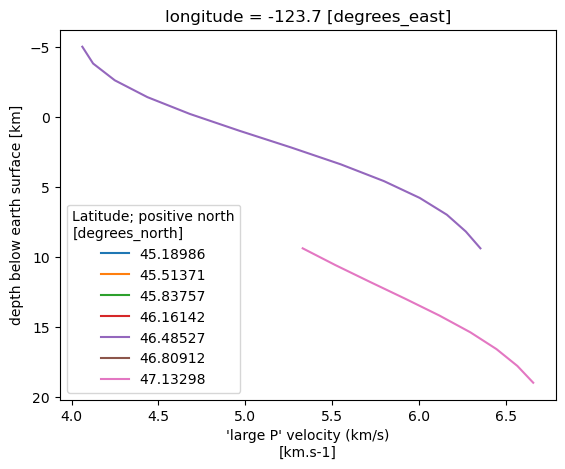

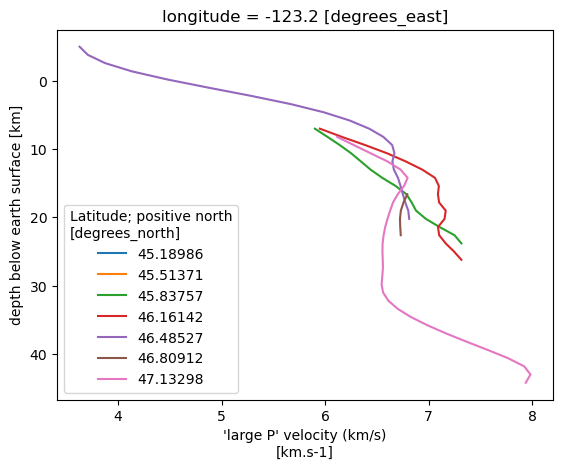

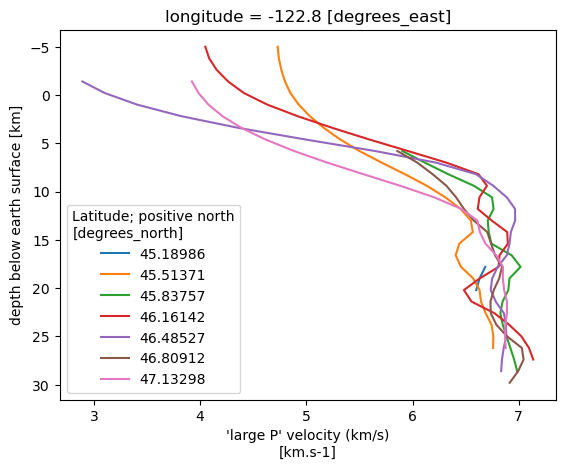

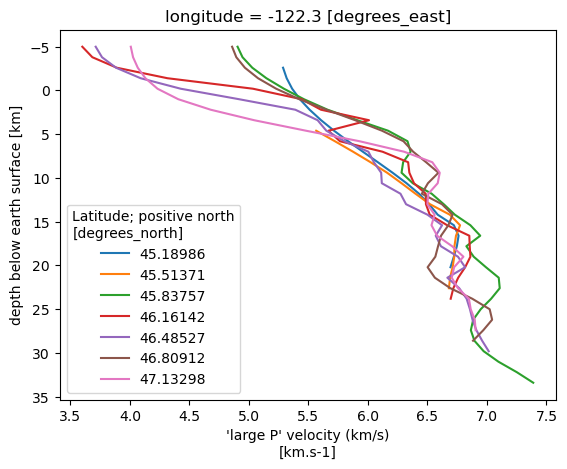

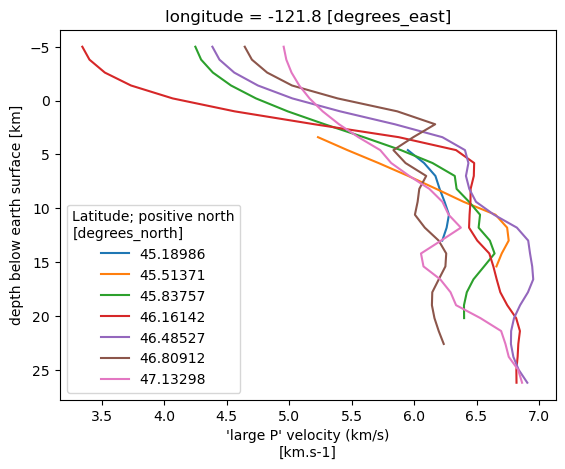

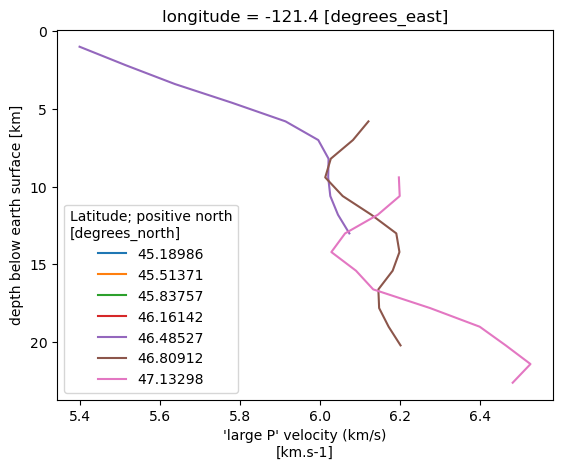

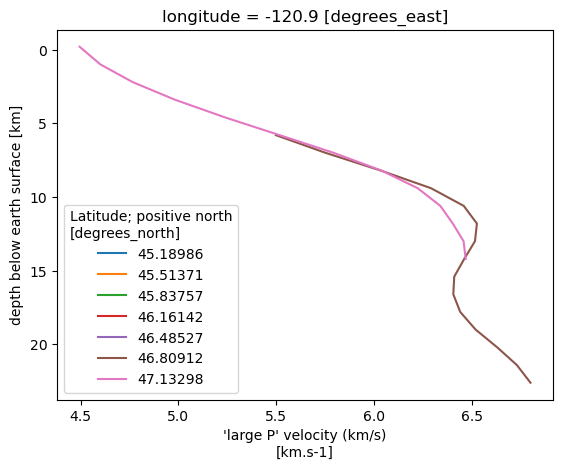



<span style='color:blue; font-weight:bold'>...done!</span>



In [13]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")

if 'xvprofile_var' not in run_args:
    xvprofile_var = run_args['default_data_var'] 
    run_args = set_run_arg(run_args, 'xvprofile_var', xvprofile_var)
elif run_args['xvprofile_var'] not in data_variables:
    xvprofile_var = run_args['default_data_var'] 
    run_args['xvprofile_var'] = xvprofile_var
    
xvslice_var = run_args['xvslice_var']

utils.message(f"Model data variables: {xvslice_var}")


xvprofile_var_wg = wg.Dropdown(options=data_variables, value=run_args['xvprofile_var'], 
                                   style={'description_width': 'initial'}, description='X-VProfile var:', 
                                   disabled=False)
changed = False
def xvp_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['xvprofile_var'] = change['new']
        change['value'] = change['new']
        changed = True
        
xvprofile_var_wg.observe(xvp_on_change)
display(xvprofile_var_wg)
if changed:
    run_args = set_run_arg(run_args, 'xvprofile_var',  xvprofile_var_wg.value)
    
x_range_wg = wg.FloatRangeSlider(
    value=run_args['x_range'],
    min=run_args['min_x'],
    max=run_args['max_x'],
    step=0.1,
    description= f"{x_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def xvp_on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['x_range'] = [change['new'][0], change['new'][1]]
    
x_range_wg.observe(xvp_on_change_0, 'value')

display(x_range_wg)

x_step = run_args['x_step']
x_step_wg = wg.IntSlider(
    value=run_args['x_step'],
    min=1,
    max=len(x_data) - 1,
    step=1,
    description=f"{x_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def xvp_on_change_3(change):
    run_args['x_step'] = change['new']

x_step_wg.observe(xvp_on_change_3, 'value')

display(x_step_wg)
    
y_range_wg = wg.FloatRangeSlider(
    value=run_args['y_range'],
    min=run_args['min_y'],
    max=run_args['max_y'],
    step=0.1,
    description=f"{y_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def xvp_on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_range'] = [change['new'][0], change['new'][1]]
    
y_range_wg.observe(xvp_on_change_1, 'value')

display(y_range_wg)

# Y step.
y_step = run_args['y_step']
y_step_wg = wg.IntSlider(
    value=run_args['y_step'],
    min=1,
    max=len(y_data) - 1,
    step=1,
    description=f"{y_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def xvp_on_change_3(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_step'] = change['new']

y_step_wg.observe(xvp_on_change_3, 'value')
display(y_step_wg)
              
# Z range.
if z_values is not None and ndim['model'] > 2:
    z_range_wg = wg.FloatRangeSlider(
    value=run_args['z_range'],
    min=run_args['min_z'],
    max=run_args['max_z'],
    step=0.1,
    description=f"{z_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    def xvp_on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_range'] = [change['new'][0], change['new'][1]]

    z_range_wg.observe(xvp_on_change_2, 'value')
    display(z_range_wg)

if ndim[xvprofile_var] != 3:
    utils.message(f"{xvprofile_var} is a {ndim[xvprofile_var]}D variable. Plot of the depth profiles is only for 3D variables", color='red')
else:  
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[xvprofile_var])
    
    x = utils.get_range_values(x_data, run_args['x_range'])
    y = utils.get_range_values(y_data, run_args['y_range'])
    z = utils.get_range_values(z_data, run_args['z_range'])
    dsv = utils.get_dsv(ds, xvprofile_var)
    for _x in x[::x_step]:
        profile = dsv.sel(longitude =_x, latitude= y[::y_step], depth= z)
        profile.plot.line(y='depth', hue='latitude')
        plt.gca().invert_yaxis()

        utils.save_files(save_data, save_plots, profile, plt, f"XP{_x:0.1f}deg", 
                         xvprofile_var, run_args['delimiter'], base_filename, run_args['file_extensions'], 
                         output_path)
        plt.show()

utils.message("...done!")

<hr />
<!--img src="assets/emc_profile_x.png" id="profiley" style="vertical-align:top; float:right;" /--> 

#### [O] Vertical Profiles Along the Y-axis
##### Plot one or more vertical profiles for a 3D model (change of parameter with depth) along the Y-axis 

* Vertical slice var - Model variable to create the vertical slices for
* X Variable range - Plot range (min, max) along the X coordinate 
* X Variable step - The step used for decimating (resampling) the X values (set to **1** for all values)
* Y Variable range - Plot range (min, max) along the Y coordinate 
* Y Variable step - The step used for decimating (resampling) the Y values (set to **1** for all values)
* Z Variable range - Plot range (min, max) along the Z coordinate 



<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>





<span style='color:blue; font-weight:bold'>Model data variables: vp_large</span>



Dropdown(description='X-VProfile var:', options=('vp_large', 'vs', 'vp_matched', 'vs_matched', 'vp'), style=De…

FloatRangeSlider(value=(-123.71399688720703, -120.69170379638672), continuous_update=False, description='Longi…

IntSlider(value=30, continuous_update=False, description='Longitude step:', max=194, min=1, style=SliderStyle(…

FloatRangeSlider(value=(45.18986129760742, 47.33808135986328), continuous_update=False, description='Latitude:…

IntSlider(value=30, continuous_update=False, description='Latitude step:', max=199, min=1, style=SliderStyle(d…

FloatRangeSlider(value=(-5.0, 59.79999923706055), continuous_update=False, description='Depth:', max=59.799999…

longitude range -123.71 to -120.69 / -123.71 to -120.69
latitude range 45.19 to 47.34 / 45.19 to 47.34
depth range -5.00 to 59.80 / -5.00 to 59.80


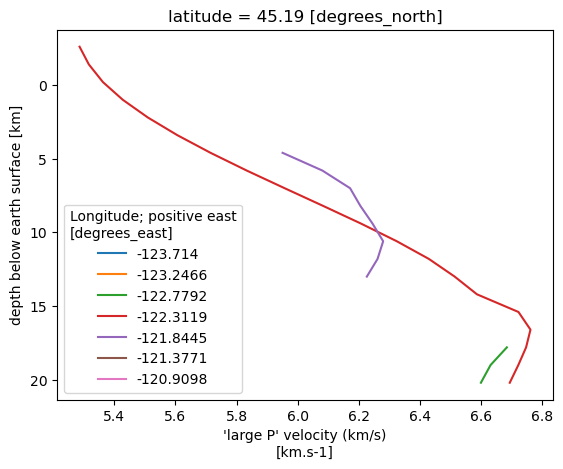

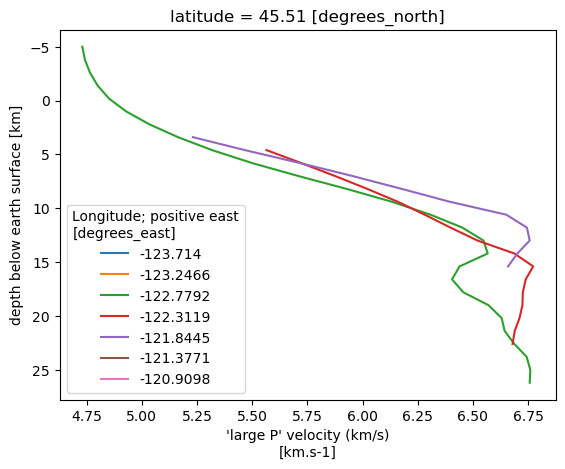

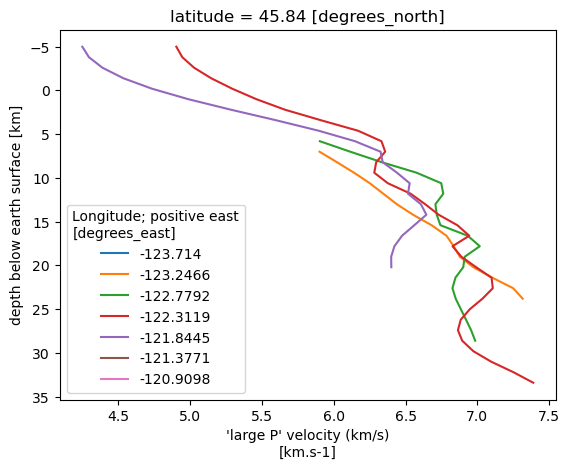

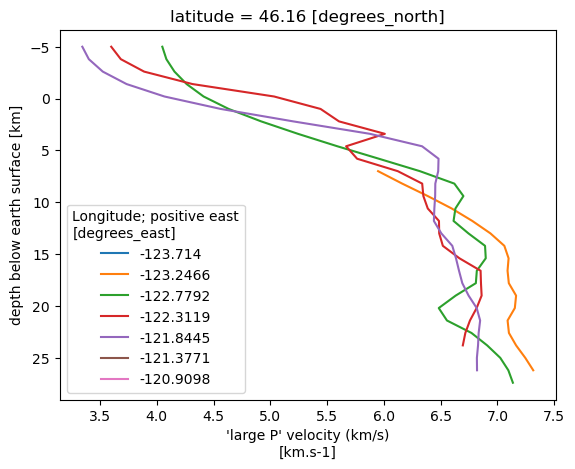

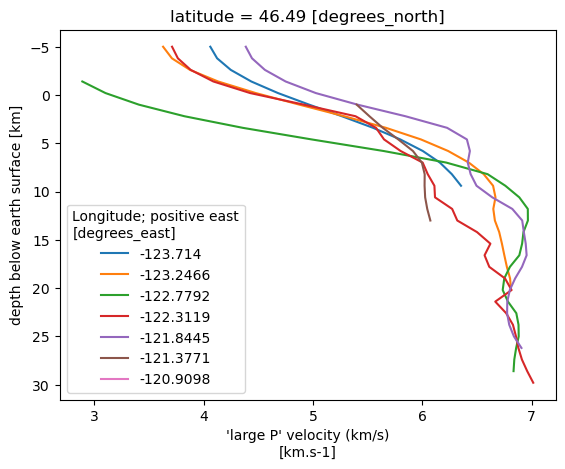

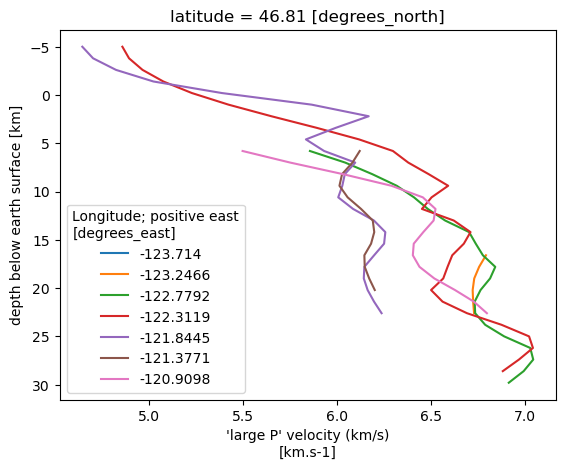

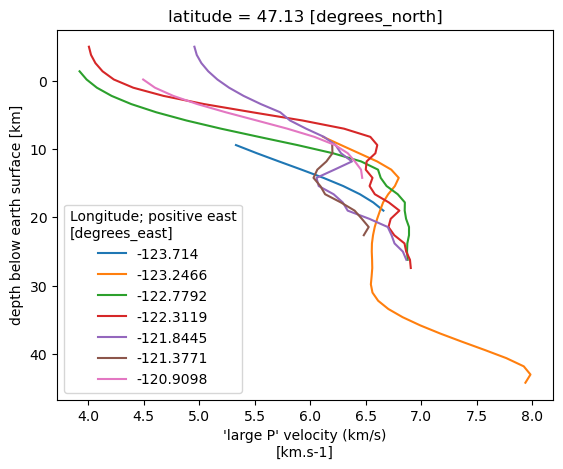



<span style='color:blue; font-weight:bold'>...done!</span>



In [14]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")

if 'yvprofile_var' not in run_args:
    yvprofile_var = run_args['default_data_var'] 
    run_args = set_run_arg(run_args, 'yvprofile_var', yvprofile_var)
elif run_args['yvprofile_var'] not in data_variables:
    yvprofile_var = run_args['default_data_var'] 
    run_args['yvprofile_var'] = yvprofile_var
    
yvprofile_var = run_args['yvprofile_var']

utils.message(f"Model data variables: {xvslice_var}")


yvprofile_var_wg = wg.Dropdown(options=data_variables, value=run_args['yvprofile_var'], 
                                   style={'description_width': 'initial'}, description='X-VProfile var:', 
                                   disabled=False)
changed = False
def yvp_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['yvprofile_var'] = change['new']
        change['value'] = change['new']
        changed = True
        
yvprofile_var_wg.observe(yvp_on_change)
display(yvprofile_var_wg)
if changed:
    run_args = set_run_arg(run_args, 'yvprofile_var',  yvprofile_var_wg.value)
    
x_range_wg = wg.FloatRangeSlider(
    value=run_args['x_range'],
    min=run_args['min_x'],
    max=run_args['max_x'],
    step=0.1,
    description= f"{x_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def yvp_on_change_0(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['x_range'] = [change['new'][0], change['new'][1]]
    
x_range_wg.observe(yvp_on_change_0, 'value')

display(x_range_wg)

x_step = run_args['x_step']
x_step_wg = wg.IntSlider(
    value=run_args['x_step'],
    min=1,
    max=len(x_data) - 1,
    step=1,
    description=f"{x_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def yvp_on_change_3(change):
    run_args['x_step'] = change['new']

x_step_wg.observe(yvp_on_change_3, 'value')

display(x_step_wg)
    
y_range_wg = wg.FloatRangeSlider(
    value=run_args['y_range'],
    min=run_args['min_y'],
    max=run_args['max_y'],
    step=0.1,
    description=f"{y_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def yvp_on_change_1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_range'] = [change['new'][0], change['new'][1]]
    
y_range_wg.observe(yvp_on_change_1, 'value')

display(y_range_wg)

# Y step.
y_step = run_args['y_step']
y_step_wg = wg.IntSlider(
    value=run_args['y_step'],
    min=1,
    max=len(y_data) - 1,
    step=1,
    description=f"{y_variable} step:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'})

def yvp_on_change_3(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_args['y_step'] = change['new']

y_step_wg.observe(yvp_on_change_3, 'value')
display(y_step_wg)
              
# Z range.
if z_values is not None and ndim['model'] > 2:
    z_range_wg = wg.FloatRangeSlider(
    value=run_args['z_range'],
    min=run_args['min_z'],
    max=run_args['max_z'],
    step=0.1,
    description=f"{z_variable}:".capitalize(),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    def yvp_on_change_2(change):
        if change['type'] == 'change' and change['name'] == 'value':
            run_args['z_range'] = [change['new'][0], change['new'][1]]

    z_range_wg.observe(yvp_on_change_2, 'value')
    display(z_range_wg)

if ndim[xvprofile_var] != 3:
    utils.message(f"{xvprofile_var} is a {ndim[xvprofile_var]}D variable. Plot of the depth profiles is only for 3D variables", color='red')
else:  
    x_data, x_min, x_max, y_data, y_min, y_max, z_data, z_min, z_max = utils.get_ranges(x_variable, x_range, x_values, 
                                                                                        y_variable, y_range, y_values, 
                                                                                        z_variable, z_range, z_values, 
                                                                                        ndim[xvprofile_var])
    
    x = utils.get_range_values(x_data, run_args['x_range'])
    y = utils.get_range_values(y_data, run_args['y_range'])
    z = utils.get_range_values(z_data, run_args['z_range'])
    dsv = utils.get_dsv(ds, xvprofile_var)
    for _y in y[::y_step]:
        profile = dsv.sel(latitude =_y, longitude= x[::x_step], depth= z)
        profile.plot.line(y='depth', hue='longitude')
        plt.gca().invert_yaxis()

        utils.save_files(save_data, save_plots, profile, plt, f"YP{_x:0.1f}deg", 
                         xvprofile_var, run_args['delimiter'], base_filename, run_args['file_extensions'], 
                         output_path)
        plt.show()

utils.message("...done!")

<hr id="outputgeocsv" />

#### Output in GeoCSV Format
##### Output the model or a subset of the model via in GeoCSV format.

* Output mode: = must be either 'single' or 'depth'
   * None: No output
   * single: a single output file
   * depth: One output file per depth (for 3D models)

* Model vars - List of the model variables to output 
* X Variable range - Output range (min, max) along the X coordinate 
* X Variable step - The step used for decimating (resampling) the X values (set to **1** for all values)
* Y Variable range - Output range (min, max) along the Y coordinate 
* Y Variable step - The step used for decimating (resampling) the Y values (set to **1** for all values)
* Z Variable range - Output range (min, max) along the Z coordinate 

In [15]:
utils.message(f"Model: {model_id}")
utils.message(f"Model file: {model_filename}")

geo_type_wg = wg.RadioButtons(
    options=['None', 'Single', 'Depth'],
    value=run_args['csv_mode'], # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='GeoCSV output type:',
    disabled=False
)

geo_output_type = wg.Output()
display(geo_type_wg, geo_output_type)

def geo_what_traits_radio(value):
    geo_output_type.clear_output()
    with geo_output_type:
        
        # Output the model in GeoCSV
        run_args['csv_mode'] = value.new
        output_mode = value.new.lower()
        if output_mode == 'none':
            return
        
        geo_data_variables_wg = wg.SelectMultiple(options=run_args['variable_list'], value=run_args['csv_data_var'], 
                                description='Model vars:', disabled=False)
        def geo_on_change(geo_change):
            if geo_change['type'] == 'change' and geo_change['name'] == 'value':
                run_args['csv_data_var'] = geo_change['new']


        geo_data_variables_wg.observe(geo_on_change)
        display(geo_data_variables_wg)

        csv_data_var = geo_data_variables_wg.value
        
        # depth: One output file per depth.
        # single: a single output file that contains all depths.

        csv_x_range_wg = wg.FloatRangeSlider(
            value=run_args['csv_x_range'],
            min=run_args['min_x'],
            max=run_args['max_x'],
            step=0.1,
            description= f"{x_variable}:".capitalize(),
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        def geo_on_change_0(change):
            if change['type'] == 'change' and change['name'] == 'value':
                run_args['csv_x_range'] = [change['new'][0], change['new'][1]]

        csv_x_range_wg.observe(geo_on_change_0, 'value')

        display(csv_x_range_wg)

        csv_x_step = run_args['csv_x_step']
        csv_x_step_wg = wg.IntSlider(
            value=run_args['csv_x_step'],
            min=1,
            max=len(x_data) - 1,
            step=1,
            description=f"{x_variable} step:".capitalize(),
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            style={'description_width': 'initial'})

        def geo_on_change_3(change):
            run_args['csv_x_step'] = change['new']

        csv_x_step_wg.observe(geo_on_change_3, 'value')

        display(csv_x_step_wg)

        csv_y_range_wg = wg.FloatRangeSlider(
            value=run_args['csv_y_range'],
            min=run_args['min_y'],
            max=run_args['max_y'],
            step=0.1,
            description=f"{y_variable}:".capitalize(),
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        def geo_on_change_1(change):
            if change['type'] == 'change' and change['name'] == 'value':
                run_args['csv_y_range'] = [change['new'][0], change['new'][1]]

        csv_y_range_wg.observe(geo_on_change_1, 'value')

        display(csv_y_range_wg)

        # Y step.
        csv_y_step = run_args['csv_y_step']
        csv_y_step_wg = wg.IntSlider(
            value=run_args['csv_y_step'],
            min=1,
            max=len(y_data) - 1,
            step=1,
            description=f"{y_variable} step:".capitalize(),
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            style={'description_width': 'initial'})

        def geo_on_change_3(change):
            if change['type'] == 'change' and change['name'] == 'value':
                run_args['csv_y_step'] = change['new']

        csv_y_step_wg.observe(geo_on_change_3, 'value')
        display(csv_y_step_wg)

        # Z range.
        if z_values is not None and ndim['model'] > 2:
            csv_z_range_wg = wg.FloatRangeSlider(
            value=run_args['csv_z_range'],
            min=run_args['min_z'],
            max=run_args['max_z'],
            step=0.1,
            description=f"{z_variable}:".capitalize(),
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            )
            def geo_on_change_2(change):
                if change['type'] == 'change' and change['name'] == 'value':
                    run_args['csv_z_range'] = [change['new'][0], change['new'][1]]

            csv_z_range_wg.observe(geo_on_change_2, 'value')
            display(csv_z_range_wg)
    
        # It is moved outside of the above, so it would not get executed with every change of parameters
        valid_modes = run_args['valid_modes']
        csv_x_range = run_args['csv_x_range']
        csv_y_range = run_args['csv_y_range']
        csv_z_range = run_args['csv_z_range']
        if output_mode not in list(valid_modes):
            raise UserWarning(f"Invalid 'output_mode' of '{output_mode}' set output_mode to one of {valid_modes} types."
                               "Stop! Please update the 'output_mode' variable")
        if len(csv_x_range) not in (0, 2):
            raise UserWarning(f"Invalid 'csv_x_range' of '{csv_x_range}' must be either and empty range for all ([]) for sould have min and max values"
                               "Stop! Please update the 'csv_x_range' variable")

        if len(csv_y_range) not in (0, 2):
            raise UserWarning(f"Invalid 'csv_y_range' of '{csv_y_range}' must be either and empty range for all ([]) for sould have min and max values"
                               "Stop! Please update the 'csv_y_range' variable")

        if len(csv_z_range) not in (0, 2):
            raise UserWarning(f"Invalid 'csv_z_range' of '{csv_z_range}' must be either and empty range for all ([]) for sould have min and max values"
                               "Stop! Please update the 'csv_z_range' variable")
geo_type_wg.observe(geo_what_traits_radio, names = 'value')
CsvStruct = namedtuple('CsvStruct', 'new')
csv_selection = CsvStruct(new=run_args['csv_mode'])
geo_what_traits_radio(csv_selection)
if run_args['csv_mode'].lower() != 'none':
    utils.make_model_geocsv(run_args, run_args['csv_mode'].lower())

# Zip the output directory for this model and then delete the directory and its content. 2022-09-19 Manoch: removed the delete option
# because after a complete run, the output directory is removed and this make rerunning any cell non-practical.
shutil.make_archive(output_path, run_args['file_extensions']['zip'].replace('.', ''), os.path.join(os.path.join(root_path, output_dir)), 
                    f"{save_tag}-{base_filename}")
# shutil.rmtree(output_path)
utils.message("...done!")




<span style='color:blue; font-weight:bold'>Model: iMUSH_localEQ_Ulberg_2020</span>





<span style='color:blue; font-weight:bold'>Model file: emc-jnp-iMUSH-localEQ-Ulberg-2020.nc</span>



RadioButtons(description='GeoCSV output type:', options=('None', 'Single', 'Depth'), value='None')

Output()



<span style='color:blue; font-weight:bold'>...done!</span>

